In [9]:
import torch
import torch.nn as nn
import numpy as np
from ase.build import molecule
from ase.calculators.emt import EMT

In [41]:


# Molecules to include
molecules = ['H2O', 'CO2']

# Number of samples per molecule
n_samples = 100

# Lists to store dataset
positions_list = []
energies_list = []
forces_list = []

for mol_name in molecules:
    base_mol = molecule(mol_name)
    base_mol.calc = EMT()  # assign EMT to original molecule
    
    for _ in range(n_samples):
        mol_copy = base_mol.copy()
        mol_copy.calc = EMT()  # assign calculator to the copy

        # Small random displacement
        displacement = 0.1 * np.random.randn(*mol_copy.positions.shape)
        mol_copy.positions += displacement
        
        # Save data
        positions_list.append(mol_copy.positions.copy())
        energies_list.append([mol_copy.get_potential_energy()])
        forces_list.append(mol_copy.get_forces().copy())

In [42]:
positions = np.array(positions_list)   # shape: (N_samples_total, N_atoms, 3)
energies = np.array(energies_list)     # shape: (N_samples_total, 1)
forces = np.array(forces_list)         # shape: (N_samples_total, N_atoms, 3)

X = torch.tensor(positions.reshape(positions.shape[0], -1), dtype=torch.float32)
Y = torch.tensor(energies, dtype=torch.float32)
F = torch.tensor(forces.reshape(forces.shape[0], -1), dtype=torch.float32)

In [48]:

model = nn.Sequential(
    nn.Linear(X.shape[1], 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 1)
)


In [49]:
criterion = nn.MSELoss()             # Energy loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [50]:
force_weight = 0.1
def loss_fn(pred_energy, true_energy, pred_forces=None, true_forces=None):
    energy_loss = nn.MSELoss()(pred_energy, true_energy)
    if pred_forces is not None:
        force_loss = nn.MSELoss()(pred_forces, true_forces)
        return energy_loss + force_weight*force_loss
    else:
        return energy_loss

In [51]:
n_epochs = 1000

for epoch in range(n_epochs):
    optimizer.zero_grad()          # Reset gradients
    y_pred = model(X)              # Forward pass
    loss = criterion(y_pred, Y)    # Compute loss
    loss.backward()                # Backpropagation
    optimizer.step()               # Update weights

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.6f}")

print("Training complete")

Epoch 0, Loss = 8.109042
Epoch 100, Loss = 1.961698
Epoch 200, Loss = 1.617110
Epoch 300, Loss = 1.126443
Epoch 400, Loss = 0.643558
Epoch 500, Loss = 0.324259
Epoch 600, Loss = 0.189885
Epoch 700, Loss = 0.120717
Epoch 800, Loss = 0.077739
Epoch 900, Loss = 0.052358
Training complete


In [ ]:
from sklearn.metrics import r2_score

pred = model(X).detach().numpy()
r2 = r2_score(energies, pred)
print(f"R² score: {r2:.4f}")


R² score: 0.9891


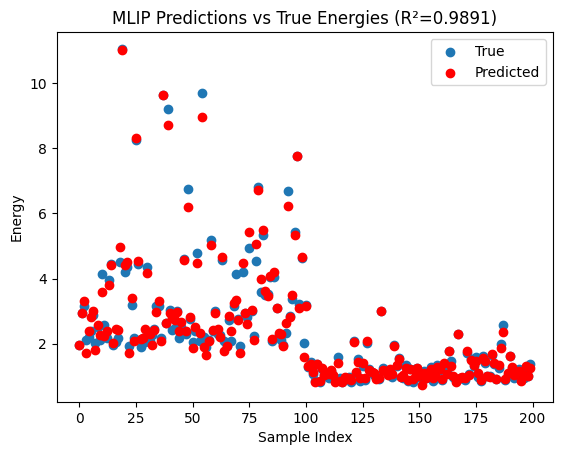

In [53]:
import matplotlib.pyplot as plt

plt.scatter(range(len(pred)), energies, label='True')
plt.scatter(range(len(pred)), pred, label='Predicted', color='red')
plt.xlabel("Sample Index")
plt.ylabel("Energy")
plt.title(f"MLIP Predictions vs True Energies (R²={r2:.4f})")
plt.legend()
plt.show()

In [54]:
torch.save(model.state_dict(), "mlip_model.pth")
np.savez("mlip_dataset.npz", X=positions, Y=energies, F=forces)